In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from gala.dynamics.actionangle.tests.staeckel_helpers import (
    galpy_find_actions_staeckel as find_actions_staeckel
)

(100.0, 275.0)

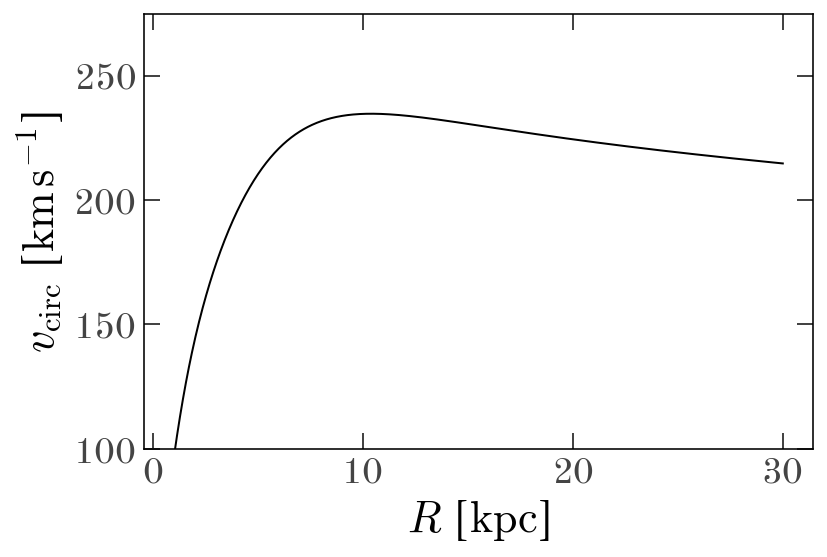

In [2]:
pot = gp.CCompositePotential()
pot['disk'] = gp.MN3ExponentialDiskPotential(
    m=6e10, 
    h_R=3.5*u.kpc, 
    h_z=0.3*u.kpc, 
    units=galactic
)
pot['halo'] = gp.NFWPotential.from_M200_c(1e12*u.Msun, 15, units=galactic)

pot.plot_rotation_curve(np.linspace(1, 30, 1024))
plt.ylim(100, 275)

In [3]:
def fz(z, sigma, pot, x0):
    z = np.atleast_1d(z)
    y = np.zeros_like(z)
    x = np.full_like(z, x0)
    psi = pot.energy(np.stack((x, y, z))) - pot.energy(np.stack((x, y, y)))
    return np.exp(- psi / sigma**2)

In [4]:
sigma = 25 * u.km/u.s

Rejection sampling to get samples in $z$

20274


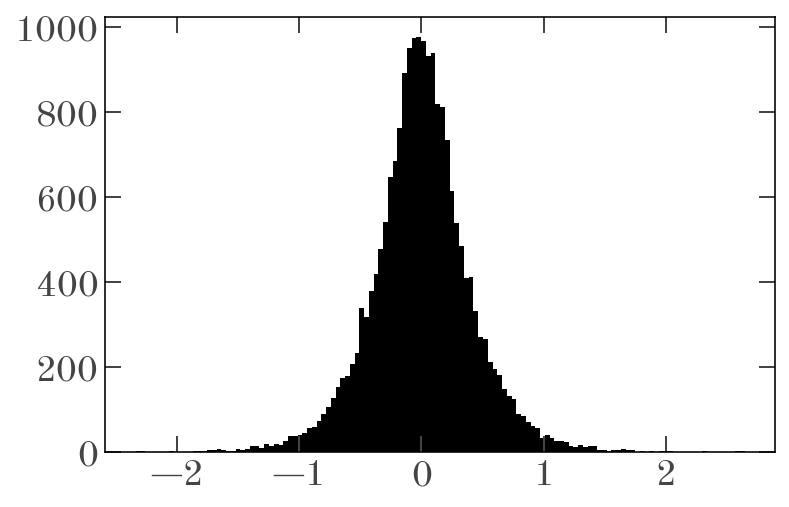

In [5]:
Nsamples = 1_000_000
rng = np.random.default_rng(seed=123)
ivt_grid = np.stack((
    rng.uniform(-20, 20, size=Nsamples),
    rng.uniform(0, 1, size=Nsamples)
))
idx = ivt_grid[1] < fz(ivt_grid[0]*u.kpc, sigma, pot, 8.*u.kpc)
z_samples = ivt_grid[0][idx] * u.kpc
print(len(z_samples))

vz_samples = rng.normal(0, sigma.value, size=len(z_samples)) * sigma.unit

plt.hist(z_samples.value, bins=128);

In [6]:
N = 16384
assert N < len(z_samples)

x0 = np.zeros((3, N)) * u.kpc
x0[0] = 8. * u.kpc
x0[2] = z_samples[:N]

v0 = np.zeros((3, N)) * u.km/u.s
v0[1] = pot.circular_velocity(x0)
v0[2] = vz_samples[:N]

w0 = gd.PhaseSpacePosition(x0, v0)

0.4060808168772894 24.914914654806854


Text(0.5, 0, '$v_z$')

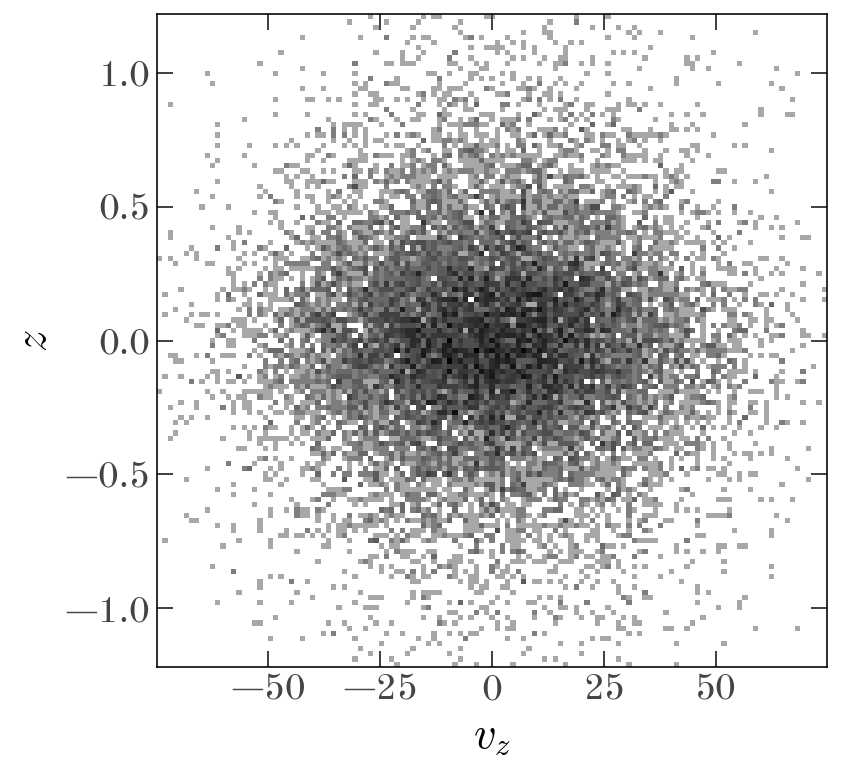

In [38]:
zz = w0.z.to_value(u.kpc)
vv = w0.v_z.to_value(u.km/u.s)
print(np.std(zz), np.std(vv))

fig, ax = plt.subplots(figsize=(6., 6))
ax.hist2d(
    vv, 
    zz,
    bins=(
        np.linspace(-3, 3, 128) * np.std(vv),
        np.linspace(-3, 3, 128) * np.std(zz),
    ),
    norm=mpl.colors.LogNorm(vmin=1e-1),
    cmap='Greys'
);
ax.set_ylabel('$z$')
ax.set_xlabel('$v_z$')

Integrate the DF for a while to make sure it's stable:

In [8]:
orbits = pot.integrate_orbit(
    w0, dt=1., n_steps=5000, 
    store_all=False
)

Checking that the DF looks stable and mixed:

0.4068082681709457 24.841860775964086


Text(0.5, 0, '$v_z$')

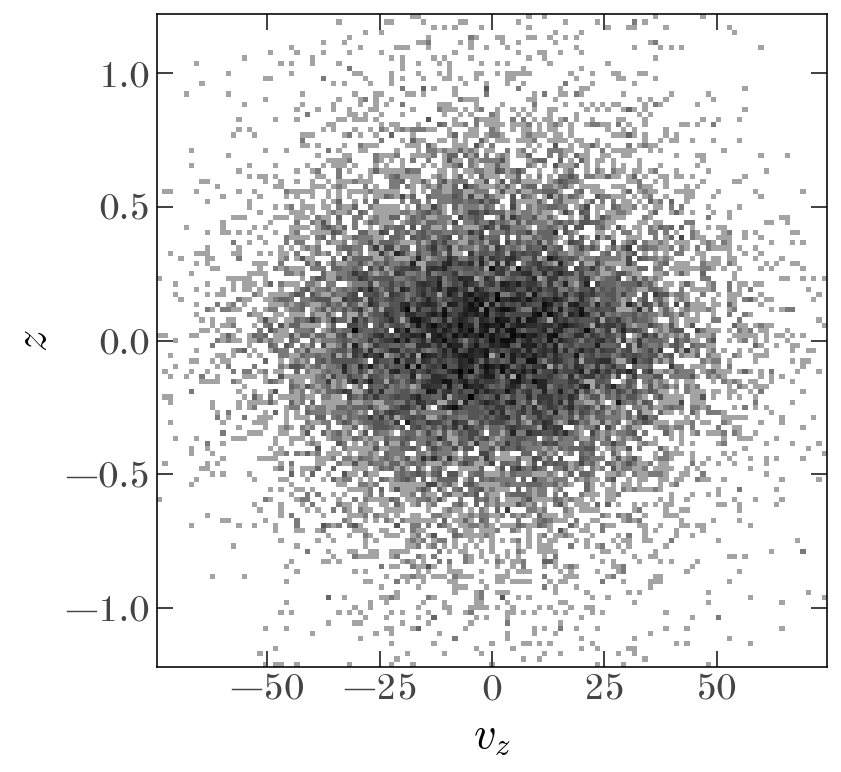

In [39]:
zz = orbits[-1].z.to_value(u.kpc)
vv = orbits[-1].v_z.to_value(u.km/u.s)
print(np.std(zz), np.std(vv))

fig, ax = plt.subplots(figsize=(6., 6))
ax.hist2d(
    vv, 
    zz,
    bins=(
        np.linspace(-3, 3, 128) * np.std(vv),
        np.linspace(-3, 3, 128) * np.std(zz),
    ),
    norm=mpl.colors.LogNorm(vmin=1e-1),
    cmap='Greys'
);
ax.set_ylabel('$z$')
ax.set_xlabel('$v_z$')

Add an impulse and run orbits forward:

Text(0.5, 0, '$v_z$')

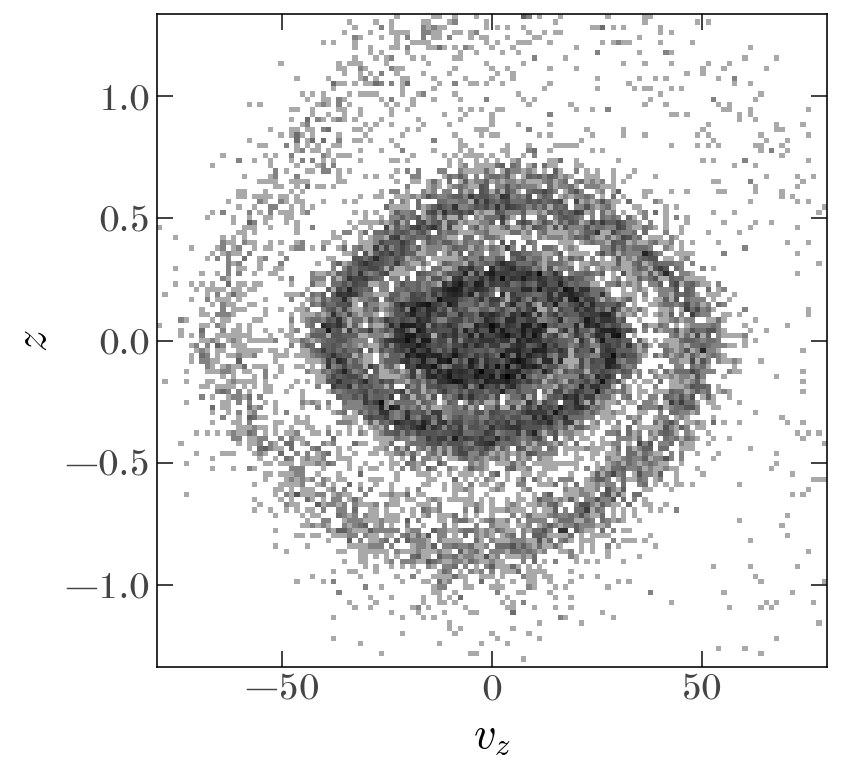

In [40]:
new_w0 = gd.PhaseSpacePosition(
    orbits[-1].xyz,
    orbits[-1].v_xyz + np.array([0, 0, 15])[:, None] * u.km/u.s
)

perturbed = pot.integrate_orbit(
    new_w0, dt=0.5, t1=0, t2=300*u.Myr,
    store_all=False
)

zz = perturbed[-1].z.to_value(u.kpc)
vv = perturbed[-1].v_z.to_value(u.km/u.s)

fig, ax = plt.subplots(figsize=(6., 6))
ax.hist2d(
    vv, 
    zz,
    bins=(
        np.linspace(-3, 3, 128) * np.std(vv),
        np.linspace(-3, 3, 128) * np.std(zz),
    ),
    norm=mpl.colors.LogNorm(vmin=1e-1),
    cmap='Greys'
);
ax.set_ylabel('$z$')
ax.set_xlabel('$v_z$')

Compute actions with unperturbed orbits and perturbed orbits in the true potential:

In [11]:
aaf0 = find_actions_staeckel(pot, w0)
sqrtJz = np.sqrt(aaf0['actions'][:, 2].value)
xx0 = sqrtJz * np.cos(aaf0['angles'][:, 2])
yy0 = sqrtJz * np.sin(aaf0['angles'][:, 2])

In [12]:
aafp = find_actions_staeckel(pot, perturbed[-1])
sqrtJz = np.sqrt(aafp['actions'][:, 2].value)
xxp = sqrtJz * np.cos(aafp['angles'][:, 2])
yyp = sqrtJz * np.sin(aafp['angles'][:, 2])

Text(0, 0.5, '$\\Omega_z$')

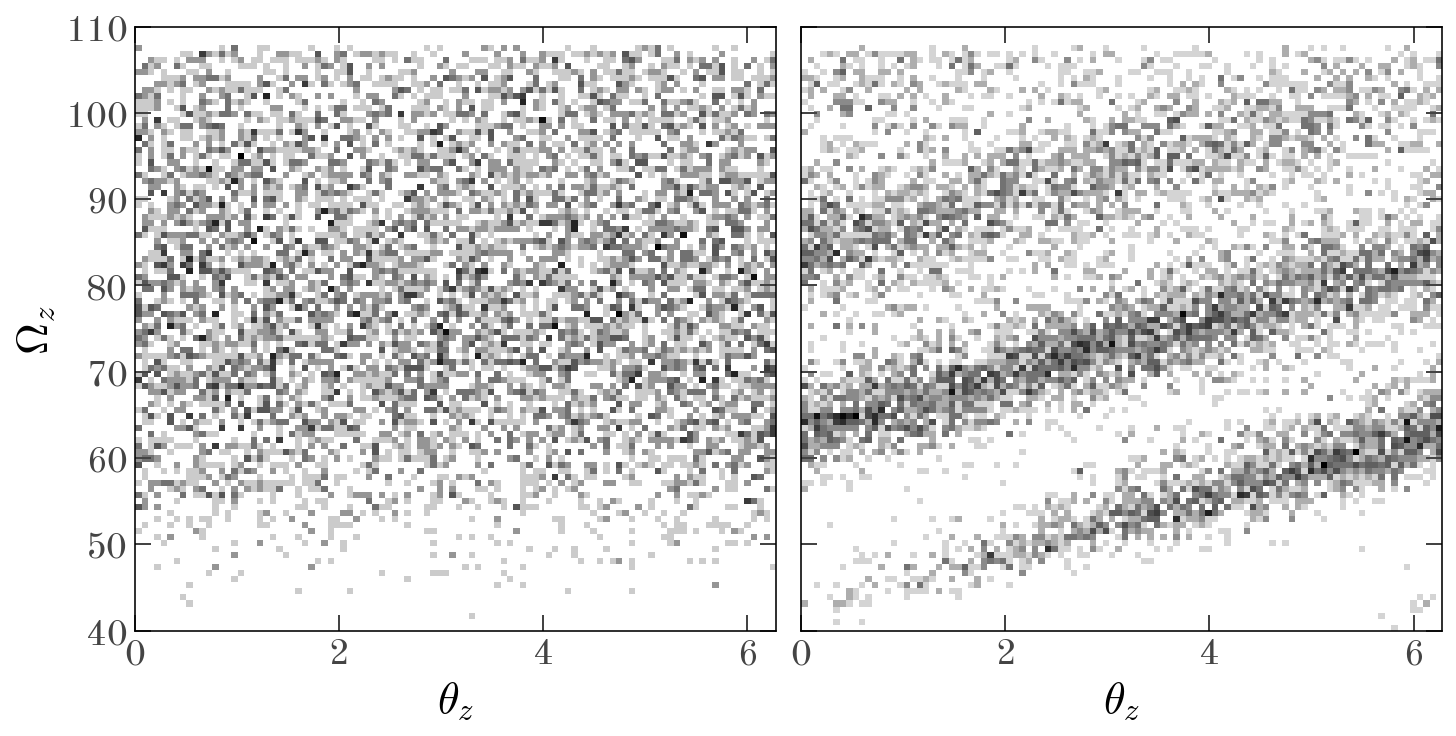

In [13]:
bins = (
   np.linspace(0, 2*np.pi, 101),
   np.linspace(40, 110, 101)
)

fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)

axes[0].hist2d(aaf0['angles'][:, 2].to_value(u.rad), 
               aaf0['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()), 
               bins=bins,
               norm=mpl.colors.LogNorm(vmin=1e0), 
               cmap='Greys');

axes[1].hist2d(aafp['angles'][:, 2].to_value(u.rad), 
               aafp['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()), 
               bins=bins,
               norm=mpl.colors.LogNorm(vmin=1e0), 
               cmap='Greys');

for ax in axes:
    ax.set_xlabel(r'$\theta_z$')
axes[0].set_ylabel(r'$\Omega_z$')

Re-compute actions for the perturbed orbits in a wrong potential:

In [14]:
wrong_pot = pot.replicate(disk={
    'h_z': 1.5 * pot['disk'].parameters['h_z'],
    'm': 1.5 * pot['disk'].parameters['m']
})

In [15]:
aafwrong = find_actions_staeckel(wrong_pot, perturbed[-1])
sqrtJz = np.sqrt(aafwrong['actions'][:, 2].value)
xxwrong = sqrtJz * np.cos(aafwrong['angles'][:, 2])
yywrong = sqrtJz * np.sin(aafwrong['angles'][:, 2])

Text(0, 0.5, '$\\sqrt{J_z} \\, \\sin{\\theta_z}$')

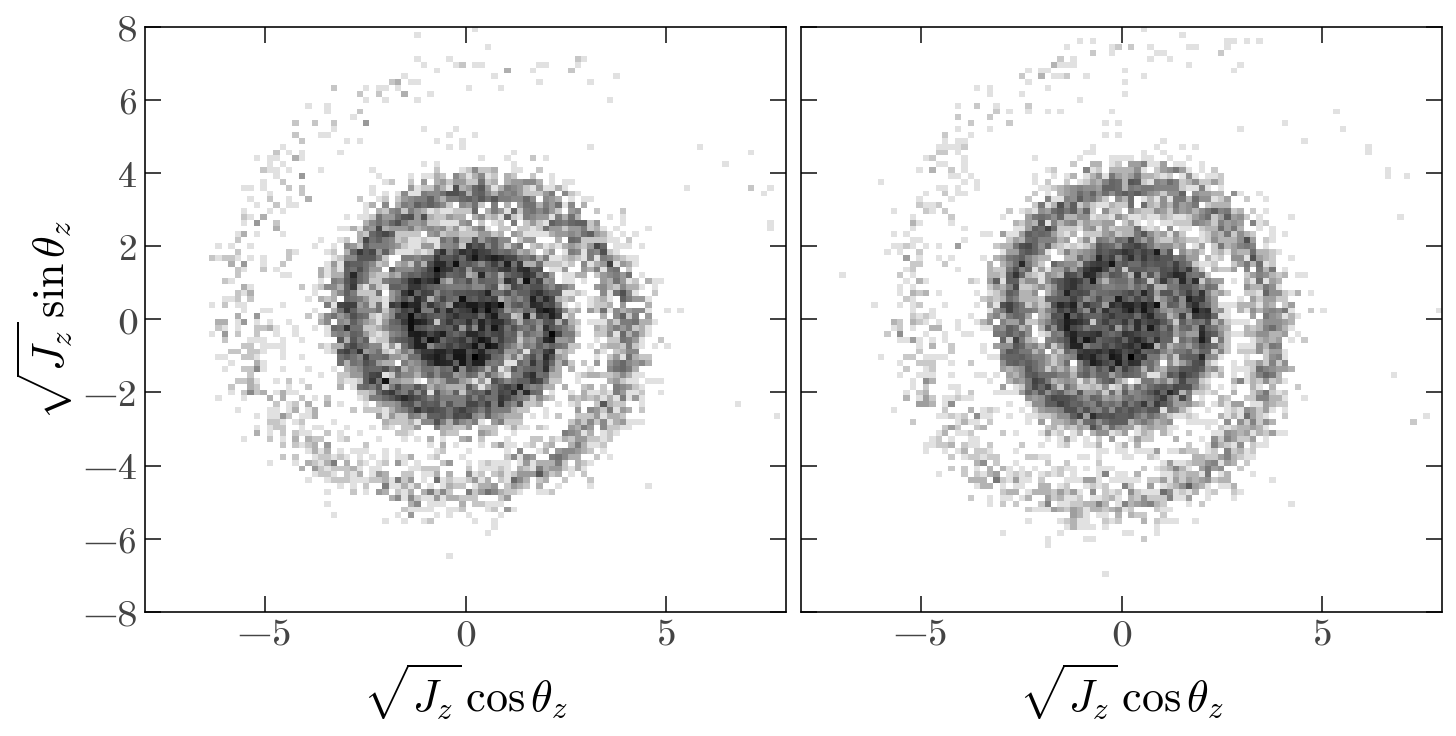

In [16]:
bins = np.linspace(-8, 8, 101)

fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)

for ax, (x, y) in zip(axes, [[xxp, yyp], [xxwrong, yywrong]]):
    ax.hist2d(x, y,
              bins=bins,
              norm=mpl.colors.LogNorm(vmin=1e0), 
              cmap='Greys');
    
for ax in axes:
    ax.set_xlabel(r'$\sqrt{J_z} \, \cos{\theta_z}$')
axes[0].set_ylabel(r'$\sqrt{J_z} \, \sin{\theta_z}$')

Text(0.5, 0, '$\\theta_z$')

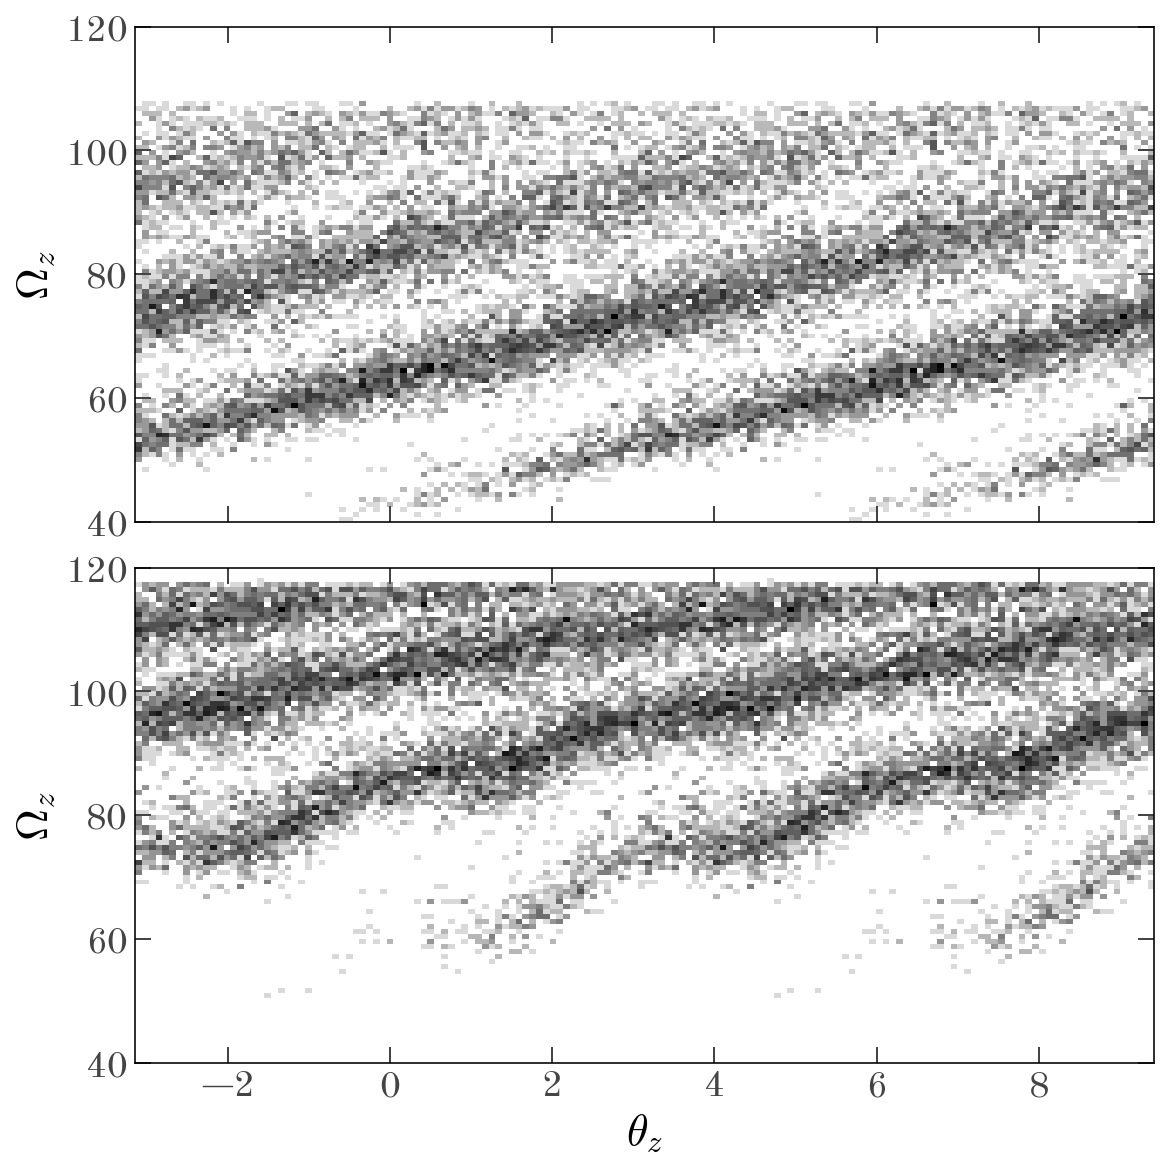

In [17]:
bins = (
   np.linspace(-np.pi, 3*np.pi, 151),
   np.linspace(40, 120, 101)
)

fig, axes = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    sharex=True, sharey=True,
    constrained_layout=True
)

for aaf, ax in zip([aafp, aafwrong], axes):
    _xx = np.concatenate((
        aaf['angles'][:, 2].to_value(u.rad) - 2*np.pi,
        aaf['angles'][:, 2].to_value(u.rad),
        aaf['angles'][:, 2].to_value(u.rad) + 2*np.pi
    ))
    _yy = np.concatenate((
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()),
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()),
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles())
    ))
    ax.hist2d(
        _xx, _yy,
        bins=bins,
        norm=mpl.colors.LogNorm(vmin=1e0), 
        cmap='Greys'
    );
    
for ax in axes:
    ax.set_ylabel(r'$\Omega_z$')
axes[-1].set_xlabel(r'$\theta_z$')

### Simulate a latitude-dependent selection function:

In [31]:
weights = np.exp(-0.5 * perturbed[-1].z**2 / (0.2 * u.kpc)**2)
weights = 1 - (weights - weights.min()) / (weights.max() - weights.min())
weights = weights * 0.7 + 0.3

(0.0, 1.02)

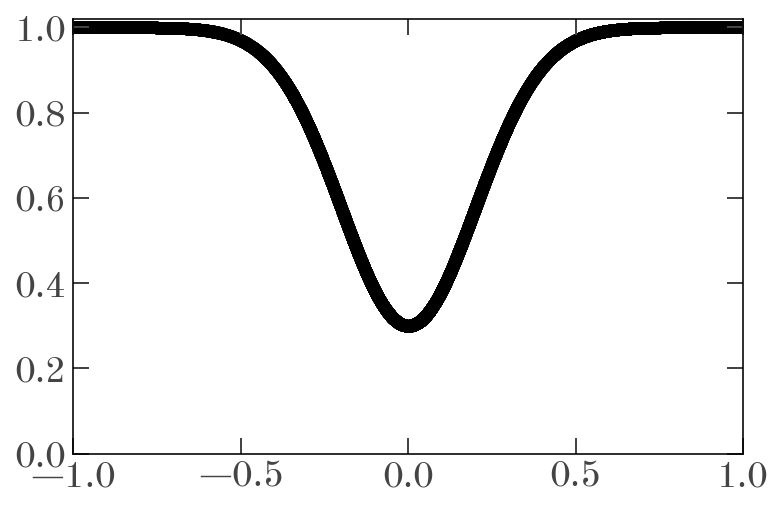

In [32]:
plt.scatter(perturbed[-1].z.value, weights.value)
plt.xlim(-1, 1)
plt.ylim(0, 1.02)

In [33]:
rng = np.random.default_rng(seed=42)
idx = rng.choice(
    perturbed.shape[1], 
    size=int(weights.sum()),
    p=weights / weights.sum()
)
len(idx)

10972

Text(0.5, 1.0, 'w/ selection function')

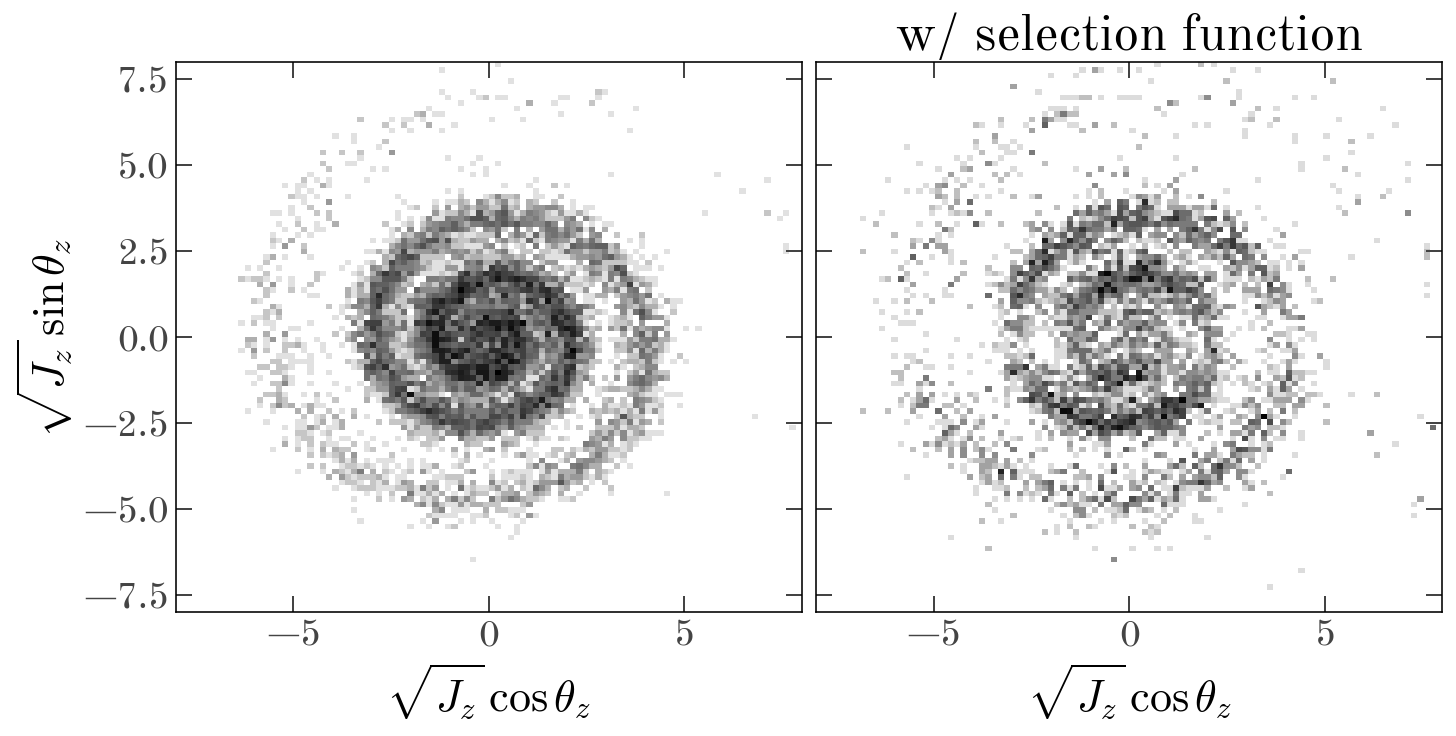

In [36]:
bins = np.linspace(-8, 8, 101)

fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)

for ax, (x, y) in zip(axes, [[xxp, yyp], [xxp[idx], yyp[idx]]]):
    ax.hist2d(x, y,
              bins=bins,
              norm=mpl.colors.LogNorm(vmin=1e0), 
              cmap='Greys');
    
for ax in axes:
    ax.set_xlabel(r'$\sqrt{J_z} \, \cos{\theta_z}$')
axes[0].set_ylabel(r'$\sqrt{J_z} \, \sin{\theta_z}$')

axes[1].set_title('w/ selection function')

Text(0.5, 0, '$\\theta_z$')

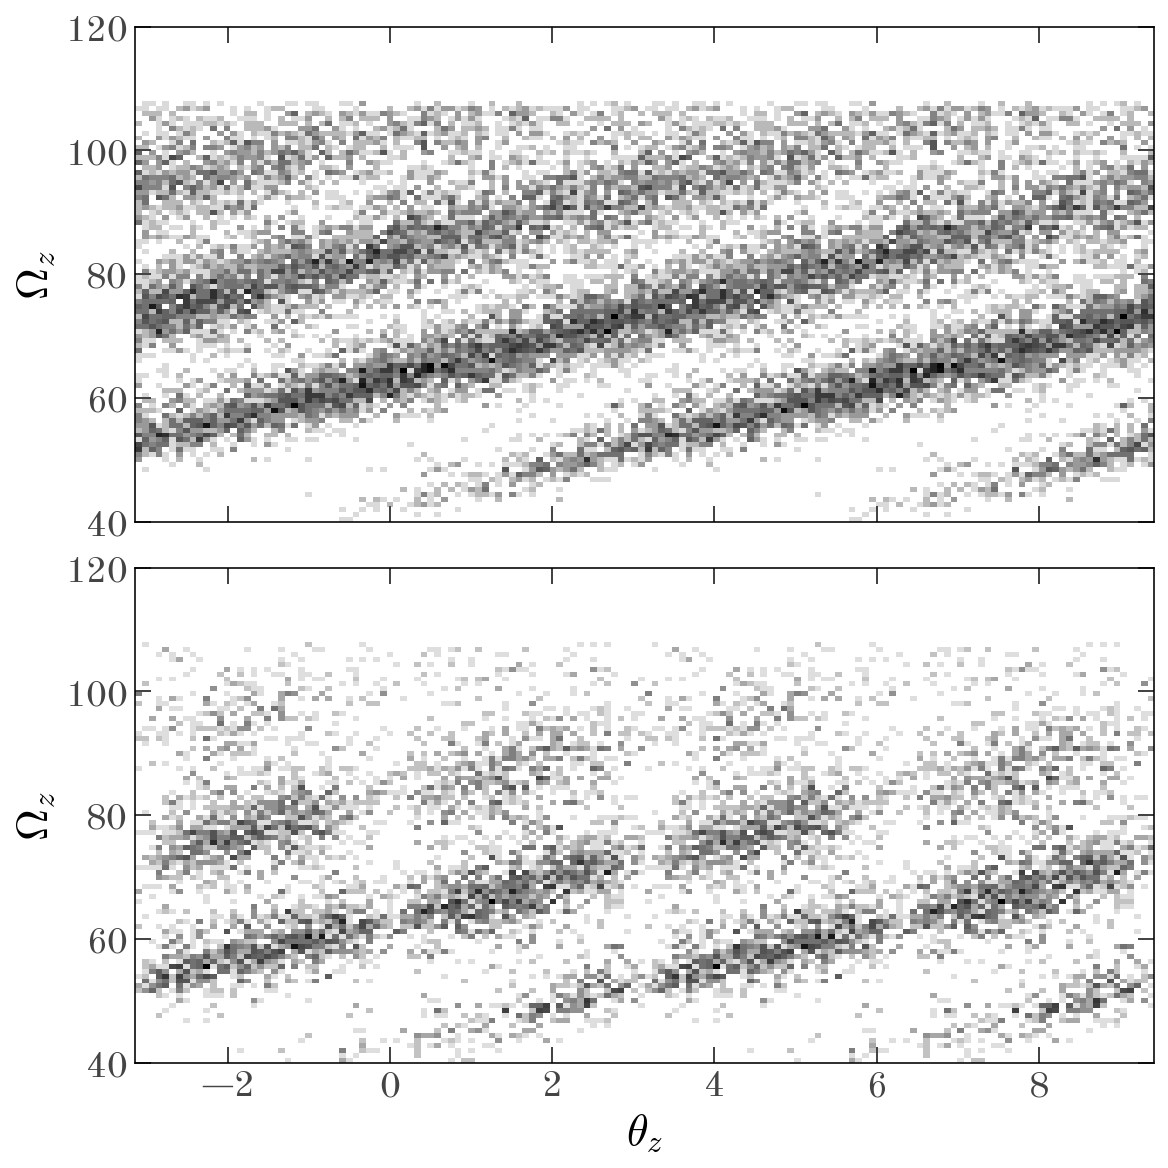

In [37]:
bins = (
   np.linspace(-np.pi, 3*np.pi, 151),
   np.linspace(40, 120, 101)
)

fig, axes = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    sharex=True, sharey=True,
    constrained_layout=True
)

for aaf, ax in zip([aafp, aafp[idx]], axes):
    _xx = np.concatenate((
        aaf['angles'][:, 2].to_value(u.rad) - 2*np.pi,
        aaf['angles'][:, 2].to_value(u.rad),
        aaf['angles'][:, 2].to_value(u.rad) + 2*np.pi
    ))
    _yy = np.concatenate((
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()),
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles()),
        aaf['freqs'][:, 2].to_value(u.rad/u.Gyr, u.dimensionless_angles())
    ))
    ax.hist2d(
        _xx, _yy,
        bins=bins,
        norm=mpl.colors.LogNorm(vmin=1e0), 
        cmap='Greys'
    );
    
for ax in axes:
    ax.set_ylabel(r'$\Omega_z$')
axes[-1].set_xlabel(r'$\theta_z$')